In [4]:
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import re

def extract_abstracts(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        content = f.read()

    # Kikeressük az 'AB  -' és a következő mező közötti részt
    abstracts = re.findall(r'AB  - (.*?)(?=\n[A-Z]{2,4} -|\n\n)', content, re.DOTALL)

    # Megtisztítjuk a sortörésektől
    clean_abstracts = [a.replace('\n      ', ' ').strip() for a in abstracts]
    return clean_abstracts

# Itt add meg a feltöltött fájlod pontos nevét!
raw_abstracts = extract_abstracts('pubmed-covid-19-set.txt')
print(f"Beolvasva: {len(raw_abstracts)} absztrakt.")

Beolvasva: 9641 absztrakt.


In [7]:
def spacy_cleaner(text):
    doc = nlp(text.lower())
    # Csak a szótövek (lemma), kidobjuk a töltelékszavakat és írásjeleket
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 2]
    return " ".join(tokens)

print("Tisztítás és lematizálás... (ez eltarthat 1-2 percig a szöveg mennyiségétől függően)")
tisztitott_korpusz = [spacy_cleaner(a) for a in raw_abstracts]
print("Kész!")

Tisztítás és lematizálás... (ez eltarthat 1-2 percig a szöveg mennyiségétől függően)
Kész!


In [8]:
# 1. SZŰRÉS: Csak a terhesség + antitest témák megtartása
target_keywords = ['antibody', 'immune', 'transfer', 'placental', 'milk', 'vaccine']

# Megnézzük, melyik tisztított szövegben van benne a 'pregnan' ÉS valamelyik antitest szó
antibody_focus_korpusz = [
    szoveg for szoveg in tisztitott_korpusz
    if ('pregnan' in szoveg or 'maternal' in szoveg) and any(k in szoveg for k in target_keywords)
]

print(f"A tisztított {len(tisztitott_korpusz)} cikkből {len(antibody_focus_korpusz)} szól az antitestekről.")

# 2. TF-IDF: Dokumentum-mátrix készítése a szűrt adatokból
from sklearn.feature_extraction.text import TfidfVectorizer

# max_df=0.7: kidobjuk a szavakat, amik a cikkek 70%-ában benne vannak (túl általánosak)
vectorizer = TfidfVectorizer(max_df=0.7, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(antibody_focus_korpusz)

# 3. KULCSSZAVAK KIMUTATÁSA
import numpy as np
feature_names = vectorizer.get_feature_names_out()
scores = tfidf_matrix.mean(axis=0).A1
top_15 = sorted(zip(scores, feature_names), reverse=True)[:15]

print("\nAz antitest-átadás legfontosabb kulcsszavai:")
for score, word in top_15:
    print(f"- {word} ({score:.4f})")

A tisztított 9641 cikkből 128 szól az antitestekről.

Az antitest-átadás legfontosabb kulcsszavai:
- vaccine (0.0832)
- vaccination (0.0523)
- woman (0.0498)
- pregnancy (0.0487)
- cov (0.0479)
- sar (0.0440)
- infection (0.0423)
- pregnant (0.0408)
- group (0.0346)
- maternal (0.0333)
- health (0.0315)
- outcome (0.0280)
- antibody (0.0273)
- risk (0.0260)
- include (0.0259)


In [9]:
from sklearn.cluster import KMeans

# Határozzuk meg, hány csoportot keressünk (legyen pl. 3 fő téma)
num_clusters = 3
km = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Lefuttatjuk a klaszterezést a mátrixon
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

# Megnézzük, melyek a legjellemzőbb szavak klaszterenként
print("--- A CIKKEK AUTOMATIKUS CSOPORTOSÍTÁSA ---")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print(f"\n{i+1}. Klaszter (Témakör) kulcsszavai:")
    # A klaszter központi szavai (top 10)
    for ind in order_centroids[i, :10]:
        print(f" * {feature_names[ind]}")

--- A CIKKEK AUTOMATIKUS CSOPORTOSÍTÁSA ---

1. Klaszter (Témakör) kulcsszavai:
 * cell
 * mrna
 * pedv
 * piglet
 * vaccine
 * pdcov
 * human
 * virus
 * viral
 * rsv

2. Klaszter (Témakör) kulcsszavai:
 * cov
 * sar
 * infection
 * pregnancy
 * group
 * woman
 * outcome
 * patient
 * maternal
 * antibody

3. Klaszter (Témakör) kulcsszavai:
 * vaccine
 * vaccination
 * woman
 * pregnant
 * pertussis
 * health
 * influenza
 * pregnancy
 * hesitancy
 * safety


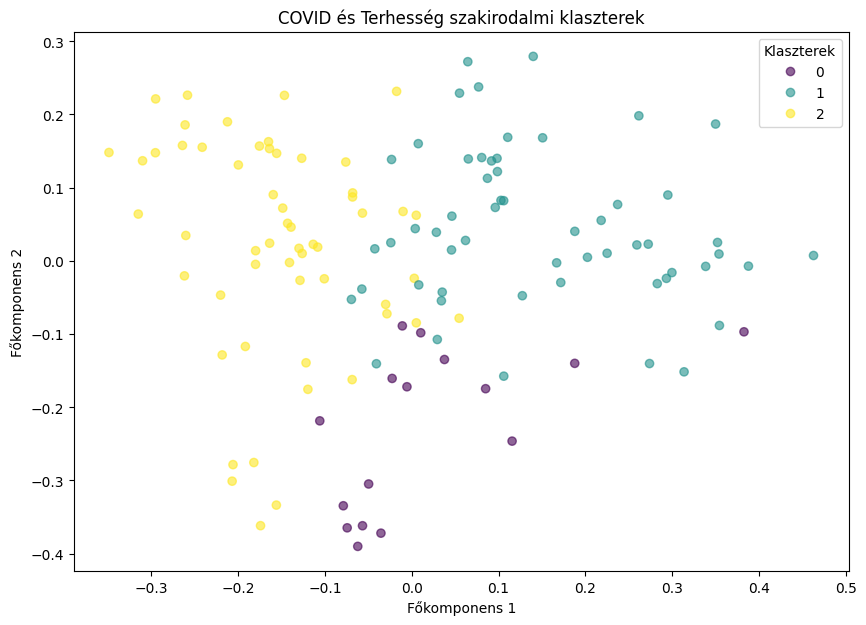

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dimenziócsökkentés 2D-re, hogy ki tudjuk rajzolni
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())

# Ábra készítése
plt.figure(figsize=(10, 7))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=clusters, cmap='viridis', alpha=0.6)

plt.title('COVID és Terhesség szakirodalmi klaszterek')
plt.xlabel('Főkomponens 1')
plt.ylabel('Főkomponens 2')
plt.legend(*scatter.legend_elements(), title="Klaszterek")
plt.show()